The workflow is:  
k-means extracts patch centers + ZCA(PCA) + fc layer + multi-class perceptron

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from autograd import grad
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_mldata

%matplotlib notebook

In [2]:
# load in data
mnist = fetch_mldata('MNIST original')

x = mnist.data.T # x.shape = (784, 70000)
x = 255 - x # digits are in black color
y = mnist.target[np.newaxis,:] # y.shape = (1, 70000)
image_length=28

In [3]:
print("input shape = " , x.shape)
print("output shape = ", y.shape)

input shape =  (784, 70000)
output shape =  (1, 70000)


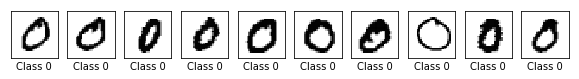

In [4]:
# Plot some of the images
plt.figure(figsize=(10, 5))
for i in range(10):
    fig = plt.subplot(1, 10, i + 1)
    xi=x[:,i]
    fig.imshow(xi.reshape(28, 28), interpolation='nearest',cmap='gray')
    fig.set_xticks(())
    fig.set_yticks(())
    fig.set_xlabel('Class %i' % y[0,i])

In [5]:
# Randomly sample the training/testing set
num_all=y.shape[1] # 70000
num_train = 60000
num_test=num_all-num_train

inds_train = np.random.permutation(y.shape[1])[:num_train] # sample indices
x_train_ori = x[:,inds_train]
y_train = y[:,inds_train]

inds_test = list(set(range(num_all))-set(inds_train))
x_test_ori = x[:,inds_test]
y_test = y[:,inds_test]

In [6]:
# Extract patches

# settings
num_patches_per_image=8
patch_length=6
# patches.shape=[patch_length*patch_length, num_train * num_patches_per_image]

# extract patches from training images
patch_max_idx=image_length-patch_length+1
num_patches=num_patches_per_image*num_train
patch_size=patch_length*patch_length
patches=np.zeros((patch_size, num_patches))
cnt=0
for i in range(num_train):
    xi=x_train_ori[:,i].reshape(28, 28)
    x0y0_rand=np.random.randint(patch_max_idx, size=(2, num_patches_per_image))
    for j in range(num_patches_per_image):
        x0=x0y0_rand[0, j]
        y0=x0y0_rand[1, j]
        patch_ij=xi[x0:x0+patch_length, y0:y0+patch_length]
        patches[:,cnt:cnt+1]=patch_ij.reshape((-1,1))
        cnt+=1

# Standardize patches
# NO! Since digits are black and white, no need to do this. Besides, there is a PCA afterward to scale the data.
IF_STANDARDIZE_PATCHES=False
def standardize_patches(x):
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis] 
    x_stds[x_stds==0]=1
    return (x - x_means)/x_stds
def standardize_one_patch(x):
    std=np.std(x)
    std=std if abs(std)>=1e-8 else 1
    return (x - np.mean(x))/std
if IF_STANDARDIZE_PATCHES:
    patches=standardize_patches(patches)

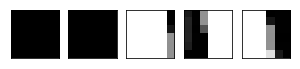

In [7]:
# Plot some patches
plt.figure(figsize=(5, 5))
for i in range(5):
    fig = plt.subplot(1, 5, i + 1)
    fig.imshow(patches[:,i].reshape(patch_length,patch_length), interpolation='nearest',cmap='gray')
    fig.set_xticks(())
    fig.set_yticks(())

In [8]:
# Call k-means
num_centers=100
kmeans = MiniBatchKMeans(num_centers).fit(patches.T)
patch_centers=kmeans.cluster_centers_.T
# shape=(patch_size, n_clusters)=(64, 100)

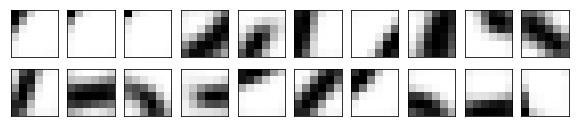

In [9]:
# Plot k-means centers
plt.figure(figsize=(10, 2))
for i in range(20):
    fig = plt.subplot(2, 10, i + 1)
    fig.imshow(patch_centers[:,i].reshape(patch_length,patch_length), interpolation='nearest',cmap='gray')
    fig.set_xticks(())
    fig.set_yticks(())

In [10]:
# Extract k-means features: (28x28 image) --> (4 x num_centers)
features_length=num_centers*4
stride_size=2

def im2col_sliding_broadcasting(A, BSZ, stepsize=1):
    # This is copied from: https://stackoverflow.com/questions/30109068/implement-matlabs-im2col-sliding-in-python
    #     and then I added the vertical stepsize
    # This functions is the same as im2col in Matlab
    M,N = A.shape
    col_extent = N - BSZ[1] + 1
    row_extent = M - BSZ[0] + 1
    start_idx = np.arange(BSZ[0])[:,None]*N + np.arange(BSZ[1]) # Get Starting block indices
    offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent) # Get offsetted indices across the height and width of input array    
    offset_idx = offset_idx[np.arange(0, offset_idx.shape[0], stepsize),:]
    offset_idx = offset_idx[:,np.arange(0, offset_idx.shape[1], stepsize)]
    return np.take (A,start_idx.ravel()[:,None] + offset_idx.ravel()[::1]) # Get all actual indices & index into input array for final output
        
def extract_features_one_sample(xi):
    xi=xi.reshape(28,28)
    # image: 28x28. Patch:8x8. Image divides to 4 subregions: [0~11) and [12~21)
    
    METHOD_VERSION_1=False
    if METHOD_VERSION_1:
        mat_patch_dis_to_center=np.zeros((num_centers,patch_max_idx,patch_max_idx))
        for i in range(patch_max_idx):
            for j in range(patch_max_idx):
                patchij=xi[i:i+patch_length, j:j+patch_length].reshape((-1,1))
                if IF_STANDARDIZE_PATCHES:
                    patchij=standardize_one_patch(patchij)
                dis_to_center=np.sqrt(np.sum((patchij-patch_centers)**2,axis=0)) #shape=(1, num_centers)
                mat_patch_dis_to_center[:,i,j]=dis_to_center
                # Further process
                # ...
    else:
        patches_in_xi = im2col_sliding_broadcasting(xi, (patch_length, patch_length), stepsize=stride_size) # 64x(21*21)/stepsize^2
        m1 = patches_in_xi[:,:,np.newaxis]
        m2 = patch_centers[:,np.newaxis,:]
        c=np.linalg.norm(m1-m2,axis=0).T # This is already the distances to centers
        # Further process
        c=np.mean(c,axis=0)-c 
        c[c<0]=0 # make it sparse. A larger element means its closer to the centroid
        new_length=np.sqrt(patches_in_xi.shape[1])
        new_length=int(new_length)
        mat_patch_dis_to_center=c.reshape(num_centers, new_length, new_length)
            
    mid=int((new_length+1)/2)
    def sum_sub(r1,r2,c1,c2):
        return np.sum(np.sum(
            mat_patch_dis_to_center[:,r1:r2,c1:c2],
            axis=1),axis=1)    
    features=np.concatenate((sum_sub(0,mid,0,mid),
                             sum_sub(0,mid,mid,new_length),
                             sum_sub(mid,new_length,0,mid),
                             sum_sub(mid,new_length,mid,new_length)
                            ), axis=0)
    return features

# Extract features for all data
def extract_features(x0):
    n=x0.shape[1]
    print("Start extracting features. Total training samples = {}:".format(n))
    x=np.zeros((features_length, n))
    for i in range(n):
        x[:,i]=extract_features_one_sample(x0[:,i])
        if i%200==0:
            print("{},".format(i),end='')
            if i>0 and i%2000==0:
                print(" ")
    return x

In [11]:
x_train=extract_features(x_train_ori)
x_test=extract_features(x_test_ori)

Start extracting features. Total training samples = 60000:
0,200,400,600,800,1000,1200,1400,1600,1800,2000, 
2200,2400,2600,2800,3000,3200,3400,3600,3800,4000, 
4200,4400,4600,4800,5000,5200,5400,5600,5800,6000, 
6200,6400,6600,6800,7000,7200,7400,7600,7800,8000, 
8200,8400,8600,8800,9000,9200,9400,9600,9800,10000, 
10200,10400,10600,10800,11000,11200,11400,11600,11800,12000, 
12200,12400,12600,12800,13000,13200,13400,13600,13800,14000, 
14200,14400,14600,14800,15000,15200,15400,15600,15800,16000, 
16200,16400,16600,16800,17000,17200,17400,17600,17800,18000, 
18200,18400,18600,18800,19000,19200,19400,19600,19800,20000, 
20200,20400,20600,20800,21000,21200,21400,21600,21800,22000, 
22200,22400,22600,22800,23000,23200,23400,23600,23800,24000, 
24200,24400,24600,24800,25000,25200,25400,25600,25800,26000, 
26200,26400,26600,26800,27000,27200,27400,27600,27800,28000, 
28200,28400,28600,28800,29000,29200,29400,29600,29800,30000, 
30200,30400,30600,30800,31000,31200,31400,31600,31800,32000, 


In [12]:
# Functions for the network

# Fully connected layer
def layer_fc(x,w):
    # N dim, P samples, C classes
    # x.shape = (N, P)
    # w.shape = (N+1, C)
    # w[1:].shape = (N, C)
    a = w[0] + np.dot(x.T,w[1:])
    a = a.T
    # a.shape = (C, P)
    # a[i][j]: the score of the jth (0~P) sample to be classified as ith (0~C) class
    return a

def cost_function_of_multiclass_perceptron(w, x, y, batch_indices=None):    
    
    # get subset of samples
    if batch_indices is not None:
        x = x[:,batch_indices] # (N, p)
        y = y[:,batch_indices] # (1, p)
    P=x.shape[1]
    
    # pre-compute predictions on all samples
    all_evals = layer_fc(x,w) # shape = (C, P)
    
    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)    
    # a.shape = (1, P), which is the highest score of each sample

    # compute cost in compact form using numpy broadcasting
    # all_evals[i,j]: score of the jth sample to be classified as class i
    i=y.astype(int).flatten() # i: the index of the correct label for each sample
    j=np.arange(P) # j: the index of each sample
    # [i,j]: extract each sample's correct class
    # all_evals[i,j]: extract the score of each sample's correct class
    b = all_evals[i,j]

    # compute cost
    cost = np.sum(a - b)
    # for the ith sample, if we predict it correctly,
    #    then a[i]==b[i]
    # Otherwise, a-b>0, which produces a cost

    # return average
    return cost/float(np.size(y))


def cost_function_of_multiclass_softmax(w, x, y, batch_indices=None):    
    # Warning: This might cause a overflow. I don't use this.
    
    # get subset of samples
    if batch_indices is not None:
        x = x[:,batch_indices] # (N, p)
        y = y[:,batch_indices] # (1, p)
    
    # pre-compute predictions on all points
    all_evals = layer_fc(x,w)
    
    # softmax sum of scores over all labels
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    # explanation: let's say there are 3 classes. Each's score is: 1, 100, 2
    # a = log(e^1 + e^100 + e^2) 
        
    # the score of the correct label
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    # explanation: If all_evals=[[1,2,3],[4,5,6]], y=[0, 1, 0],
    # then b=[1,5,3]
    
    # cost function
    cost = np.sum(a - b)
    # if b is very large, then the weight of b in the total sum is very large,
    #     and cost=(a-b) is very small. then we know we are making a good prediction.
    
    # return average
    return cost/float(np.size(y))

cost_function=cost_function_of_multiclass_perceptron

In [13]:
# Minibatch gradient descent + Diminishing step length + Momentum
def gradient_descent(g, alpha, max_epochs, w, num_train, batch_size,
                        step_length_idx_start_diminish=99999, mom_b=0.8, print_interval=-1):
    # Input:
    #   g: MUST HAVE 2 ARGUMENTS!!! g(w, batch_indices)
    #       Besides, inside g, it should use the global vars of sample_x and sample_y
    # Output:
    #   w_hist: history of weight 
    #   train_hist: history of cost on training set
    
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w)
    
    # calc gradient
    grad = value_and_grad(g_flat)

    # list for storing history
    w_hist = [unflatten(w)]
    train_hist = [g_flat(w,np.arange(num_train))]
   
    # num_batches * batch_size == number of samples
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))
    
    # Momentum: h=b*h+(1-b)*dw
    mom_h=np.zeros(w.shape)
    
    # Iterate epochs
    for k in range(max_epochs):      
             
        # print current Epoch
        if print_interval>0:
            if k % print_interval==0:
                print("Epoch %d, " % k, end='')
            if (k+1) % (10*print_interval)==0:
                print("")
        
        # loop over each minibatch
        for b in range(num_batches):
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))
            
            # plug in value into func and derivative
            cost_eval,grad_eval = grad(w, batch_inds)
            grad_eval.shape = np.shape(w)
    
            # take a descent step
            dw = -alpha/max(k-step_length_idx_start_diminish,1)*grad_eval
            mom_h=mom_b*mom_h+(1-mom_b)*dw # momentum
            w = w + mom_h
        
        # update training and validation cost
        train_cost = g_flat(w, np.arange(num_train))
        # record weight update, train and val costs
        w_hist.append(unflatten(w))
        train_hist.append(train_cost)

    return w_hist,train_hist

In [14]:
# Data pre-processing

# def standard_normalizer(x):
#     x_means = np.mean(x,axis = 1)[:,np.newaxis]
#     x_stds = np.std(x,axis = 1)[:,np.newaxis]       
#     x_stds[x_stds==0]=1 # Add this to avoid deviding 0 !!!!
#     normalizer = lambda data: (data - x_means)/x_stds # create standard normalizer function
#     inverse_normalizer = lambda data: data*x_stds + x_means # create inverse standard normalizer
#     return normalizer,inverse_normalizer

def PCA(x, lam = 10**(-6)):
    # x:  shape = (N, P). Each row is a feature. Each column is a sample. Already removed mean.    
    Cov = 1.0/x.shape[1]*np.dot(x,x.T) + lam*np.eye(x.shape[0])
    d,W = np.linalg.eigh(Cov) # eigenvalues / vectors of correlation matrix
    return d,W
    # A chinese tutorial: https://www.zhihu.com/question/39234760

global W, x_means, x_stds
# PCA-sphereing - use PCA to normalize input features
def ZCA_whitening(x, num_new_features=-1):
    global W, x_means, x_stds
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means
    USE_SVD=False
    if USE_SVD: # This generates a memory error
        u, s, vh = np.linalg.svd(x_centered, full_matrices=True) 
        W=u
        x_stds=s
    else:
        d,W = PCA(x_centered)
        x_stds = np.std( np.dot(W.T,x_centered) ,axis = 1)[:,np.newaxis]
        x_stds[x_stds==0]=1
    if num_new_features>0:
        W=W[:,-num_new_features:]
        x_stds=x_stds[-num_new_features:,0:1]
    normalizer = lambda data: np.dot(W.T,data - x_means)/x_stds
    inverse_normalizer = lambda data: np.dot(W,data*x_stds) + x_means
    return normalizer,inverse_normalizer

In [15]:
# ZCA, normalize features
num_reduced_features=100 # Use part of the coordinates that have the largest eigen values
                    # Set to -1 to use all features
normalizer, inverse_normalizer=ZCA_whitening(x_train, num_reduced_features)
x_train_norm = normalizer(x_train)

In [34]:
# Start training
import warnings
warnings.filterwarnings("error")

# set para
N = x_train_norm.shape[0]  # number of features
C = len(np.unique(y_train)) # 10 classes
w0 = 0.001*np.random.randn(N + 1, C) # 785*10, weights
batch_size = 1000
num_epochs = 20

step_length = 1e-2
step_length_idx_start_diminish=1

def g(w, batch_indices):
    return cost_function(w, x_train_norm, y_train, batch_indices)+0.0*(w**2).sum()

w_hist, cost_hist = gradient_descent(\
    g, step_length, num_epochs, w0, num_train, batch_size,
    step_length_idx_start_diminish, mom_b=0, print_interval=5) # mom_b: 0 for no history consideration. 
print("\nOptimization finishes.")
final_weight=w_hist[-1]

Epoch 0, Epoch 5, Epoch 10, Epoch 15, 
Optimization finishes.


In [35]:
# function: predict labels
def predict(x, w, y):
    all_evals = layer_fc(x, w)
    y_predict = np.argmax(all_evals, axis=0)
    accuracy = np.sum(y_predict==y) / y.shape[1]
    return (y_predict, accuracy)

x_test_zca = normalizer(x_test)
accu_hist_train=[]
accu_hist_test=[]
for i, w in enumerate(w_hist):
    (y_predict, accuracy) = predict(x_test_zca, w, y_test)
    accu_hist_test.append(accuracy)    
    (y_predict, accuracy) = predict(x_train_norm, w, y_train)
    accu_hist_train.append(accuracy)    

Number of epochs = 20, Method = ZCA whitening, steplen=0.01

Accuracy: Training set = 98.27 %, Testing set = 97.20 %


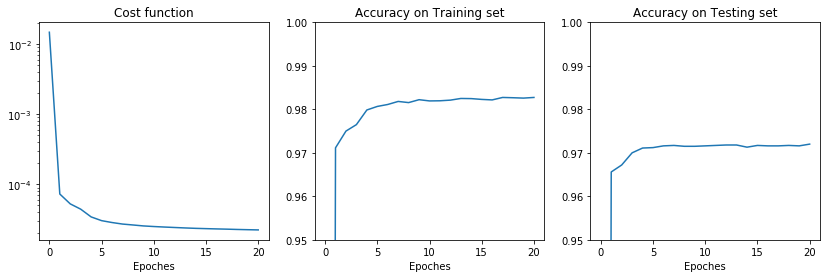

In [36]:
# Print result
print("Number of epochs = {}, Method = ZCA whitening, steplen={}".format(num_epochs, step_length))
print("\nAccuracy: Training set = {:.2f} %, Testing set = {:.2f} %".format(
    accu_hist_train[-1]*100,accu_hist_test[-1]*100))

xlabel="Epoches"
xdata=range(num_epochs+1)
fig=plt.figure(figsize=(14, 4))

# Cost function
plt.subplot(131)
plt.plot(xdata, cost_hist)
plt.xlabel(xlabel)
plt.yscale("log")
plt.title("Cost function")

# Accuracy on Training set
plt.subplot(132)
plt.plot(xdata, accu_hist_train)
plt.xlabel(xlabel)
plt.title("Accuracy on Training set")
plt.ylim((0.95,1))

# Accuracy on Testing set
plt.subplot(133)
plt.plot(xdata, accu_hist_test)
plt.xlabel(xlabel)
plt.title("Accuracy on Testing set")
plt.ylim((0.95,1))


plt.show()

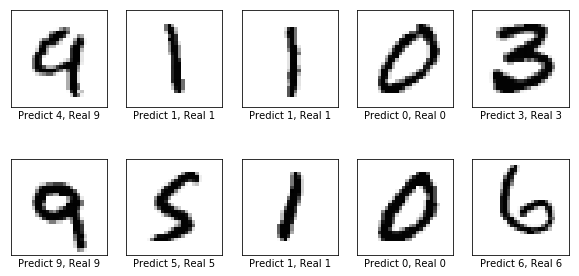

In [37]:
# Plot images and see if predictions are correct
plt.figure(figsize=(10, 5))
for i in range(10):
    fig = plt.subplot(2, 5, i + 1)
    idx=np.random.randint(num_test)
    xi_ori=x_test_ori[:,idx:idx+1]
    yi_real=y_test[0, idx]
    xi=extract_features_one_sample(xi_ori)[:,np.newaxis]
    xi_norm=normalizer(xi)
    all_evals = layer_fc(xi_norm, final_weight)
    yi_predict = np.argmax(all_evals, axis=0)
    fig.imshow(xi_ori.reshape(28, 28), interpolation='nearest',cmap='gray')
    fig.set_xticks(())
    fig.set_yticks(())
    fig.set_xlabel('Predict %d, Real %d' % (yi_predict,yi_real))

## Training ends here.
## Now I will output the necessary data for my C program.

In [20]:
idx_image=0;
test_image_label=int(y_train[0, idx_image])
test_image_array=x_train_ori[:,idx_image]
num_labels=len(np.unique(y_train))

In [26]:
# Write params to file, so later Cpp file could use them.
def np2str(nparray):
    return np.array2string(nparray, precision=8, separator=',',threshold=999999999,
                      suppress_small=True).replace("[","{").replace("]","}")

with open("digit_classifier_data.h", "w") as fo:
    
    fo.write("// This file stores the weights trained in Python which are used for classifying digit.\n")
    fo.write("//     A test image is also included.\n")
    fo.write("// Notice: This file is automatically generated by Python script,\n")
    fo.write("//     and should only be included by 'digit_classifier.cpp'.\n")
    
    fo.write("\nconst int image_length={};".format(image_length))
    fo.write("\nconst int patch_length={};".format(patch_length))
    fo.write("\nconst int patch_size={};".format(patch_length*patch_length))
    fo.write("\nconst int num_centers={};".format(num_centers))
    fo.write("\nconst int stride_size={};".format(stride_size))
    fo.write("\nconst int num_labels={};".format(num_labels))
    fo.write("\nconst int num_reduced_features={};".format(num_reduced_features))
    
    
    fo.write("\nconst unsigned char test_image_label={};".format(test_image_label))
    
    fo.write("\nunsigned char _test_image[image_length][image_length]=")
    fo.write(np2str(test_image_array.reshape(image_length, image_length)))
    fo.write(";")
    
    # patch centers
    
    fo.write("\n\nconst double patch_centers[patch_size][num_centers]=")
    fo.write(np2str(patch_centers))
    fo.write(";")
    
    # ZCA
    
    fo.write("\n\nconst double x_means[4*num_centers]=")
    fo.write(np2str(np.squeeze(x_means)))
    fo.write(";")

    fo.write("\n\nconst double x_stds[num_reduced_features]=")
    fo.write(np2str(np.squeeze(x_stds)))
    fo.write(";")
    
    fo.write("\n\nconst double WT[num_reduced_features][4*num_centers]=")
    fo.write(np2str(W.T))
    fo.write(";")
    
    # weights
    
    fo.write("\n\nconst double final_weight[1+num_reduced_features][num_labels]=")
    fo.write(np2str(final_weight))
    fo.write(";")  
    

[]

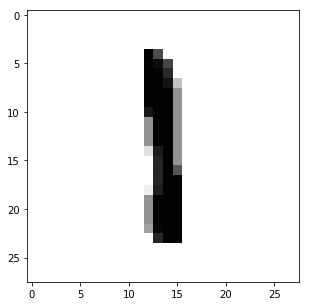

In [22]:
# DEBUG: Plot test image
fig=plt.figure(figsize=(10, 5))

xi_ori=x_train_ori[:,idx_image:idx_image+1]
yi_real=y_train[0, idx_image]
xi=extract_features_one_sample(xi_ori)[:,np.newaxis]
xi_norm=normalizer(xi)
# print("Features after normalization: ", xi_norm[0:10])
all_evals = layer_fc(xi_norm, final_weight)
# print("Each label's score: ", all_evals.T)
yi_predict = np.argmax(all_evals, axis=0)

plt.imshow(xi_ori.reshape(28, 28), interpolation='nearest',cmap='gray')
plt.plot()